In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skforecast.recursive import ForecasterEquivalentDate, ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from lightgbm import LGBMRegressor
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster

In [2]:
# load dataset
df = pd.read_csv('data/dataset.csv', delimiter=';')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime').sort_index()

In [3]:
# create train and validation sets
df_power = df[['Power']]
data_train = df_power.loc['2015-01-01':'2023-12-31'].asfreq('h')
data_val = df_power.loc['2024-01-01':'2024-01-14'].asfreq('h')

In [4]:
# baseline model: seasonal naive forecast
forecaster = ForecasterEquivalentDate(
                 offset = pd.DateOffset(days=1),
                 n_offsets = 1)

forecaster.fit(y=data_train['Power'])
forecaster

======================== 
ForecasterEquivalentDate 
======================== 
Offset: <DateOffset: days=1> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 24 
Series name: Power 
Training range: [Timestamp('2015-01-05 00:00:00+0000', tz='UTC'), Timestamp('2023-12-31 23:00:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: <Hour> 
Creation date: 2025-12-04 16:04:36 
Last fit date: 2025-12-04 16:04:36 
Skforecast version: 0.19.0 
Python version: 3.13.0 
Forecaster id: None

  0%|          | 0/14 [00:00<?, ?it/s]

   mean_absolute_error
0            64.145833


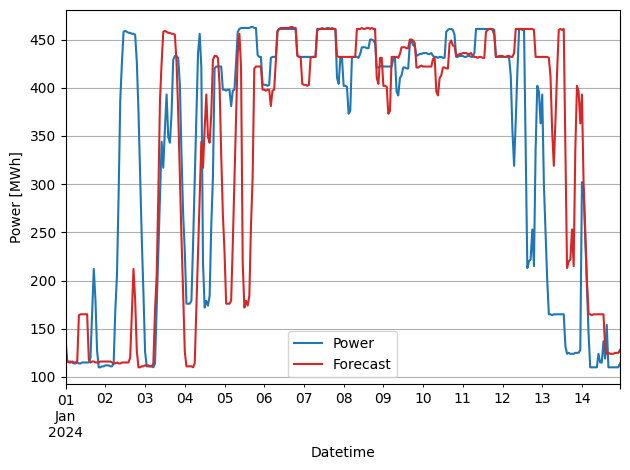

In [5]:
# backtesting
cv = TimeSeriesFold(
        steps              = 24,
        initial_train_size = len(data_train['Power']),
        refit              = False
)

metric, predictions = backtesting_forecaster(
                          forecaster = forecaster,
                          y          = df_power.loc['2015-01-01':'2024-01-14']['Power'].asfreq('h'),
                          cv         = cv,
                          metric     = 'mean_absolute_error'
                       )
print(metric)

# plot
val_week = df_power.loc[predictions.index.min():predictions.index.max()]
fig, ax = plt.subplots()
val_week.plot(ax=ax, label='Actual Power', color='tab:blue')
predictions['pred'].plot(ax=ax, label='Forecast', color='tab:red')
plt.ylabel("Power [MWh]")
plt.xlabel("Datetime")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# recursive autoregressive model: recursive multi-step forecasting
window_features = RollingFeatures(stats=["mean"], window_sizes=24 * 3)
forecaster = ForecasterRecursive(
                 estimator       = LGBMRegressor(random_state=15926, verbose=-1),
                 lags            = 24,
                 window_features = window_features
             )

forecaster.fit(y=data_train['Power'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Estimator: LGBMRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: ['roll_mean_72'] 
Window size: 72 
Series name: Power 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2015-01-05 00:00:00+0000', tz='UTC'), Timestamp('2023-12-31 23:00:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: <Hour> 
Estimator parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample':
    1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-12-04 16:04:37 
Last fit date: 2025-12-04 16:04:38 
Skforecast version: 0.19.0 
Python version: 3.13.0 
Forecaster id: None

  0%|          | 0/14 [00:00<?, ?it/s]

   mean_absolute_error
0            63.989382


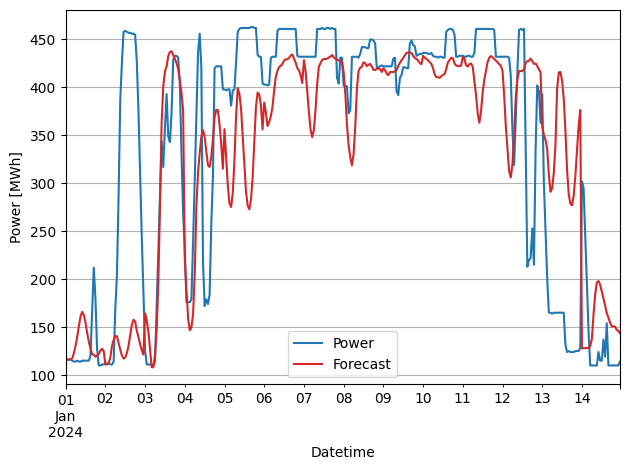

In [7]:
# backtesting
metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = df_power.loc['2015-01-01':'2024-01-14']['Power'].asfreq('h'),
                          cv            = cv,
                          metric        = 'mean_absolute_error',
                          verbose       = False,
                      )
print(metric)

# plot
val_week = df_power.loc[predictions.index.min():predictions.index.max()]
fig, ax = plt.subplots()
val_week.plot(ax=ax, label='Actual Power', color='tab:blue')
predictions['pred'].plot(ax=ax, label='Forecast', color='tab:red')
plt.ylabel("Power [MWh]")
plt.xlabel("Datetime")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
exog_features = df.drop(columns=['Power']).columns.tolist()
data_train_exog = df.loc['2015-01-01':'2023-12-31', exog_features].asfreq('1h')
data_val_exog = df.loc['2024-01-01':'2024-01-14', exog_features].asfreq('1h')

forecaster = ForecasterRecursive(
    regressor = LGBMRegressor(random_state=123, verbose=-1),
    lags = 24
)

forecaster.fit(
    y = data_train['Power'],
    exog = data_train_exog
)

/var/folders/m0/905_fhw57xq6x9rdt2gw2q380000gn/T/ipykernel_72555/1851467588.py:5: FutureWarning: The `regressor` argument is deprecated and will be removed in a future version. Please use `estimator` instead.
  forecaster = ForecasterRecursive(


╭──────────────────────────────── MissingValuesWarning ────────────────────────────────╮
│ `exog` has missing values. Most machine learning models do not allow missing values. │
│ Fitting the forecaster may fail.                                                     │
│                                                                                      │
│ Category : skforecast.exceptions.MissingValuesWarning                                │
│ Location :                                                                           │
│ /Users/leon/.pyenv/versions/pja/lib/python3.13/site-packages/skforecast/utils/utils. │
│ py:569                                                                               │
│ Suppress : warnings.simplefilter('ignore', category=MissingValuesWarning)            │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location :                                                                           │
│ /Users/leon/.pyenv/versions/pja/lib/python3.13/site-packages/skforecast/utils/utils. │
│ py:640                                                                               │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

In [10]:
metric, predictions = backtesting_forecaster(
    forecaster = forecaster,
    y = df.loc['2015-01-01':'2024-01-14', 'Power'].asfreq('h'),
    exog = df.loc['2015-01-01':'2024-01-14', exog_features].asfreq('h'),
    cv = cv,
    metric = 'mean_absolute_error'
)

╭──────────────────────────────── MissingValuesWarning ────────────────────────────────╮
│ `exog` has missing values. Most machine learning models do not allow missing values. │
│ Fitting the forecaster may fail.                                                     │
│                                                                                      │
│ Category : skforecast.exceptions.MissingValuesWarning                                │
│ Location :                                                                           │
│ /Users/leon/.pyenv/versions/pja/lib/python3.13/site-packages/skforecast/utils/utils. │
│ py:569                                                                               │
│ Suppress : warnings.simplefilter('ignore', category=MissingValuesWarning)            │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────── DataTypeWarning ───────────────────────────────────╮
│ `exog` may contain only `int`, `float` or `category` dtypes. Most machine learning   │
│ models do not allow other types of values. Fitting the forecaster may fail.          │
│                                                                                      │
│ Category : skforecast.exceptions.DataTypeWarning                                     │
│ Location :                                                                           │
│ /Users/leon/.pyenv/versions/pja/lib/python3.13/site-packages/skforecast/utils/utils. │
│ py:640                                                                               │
│ Suppress : warnings.simplefilter('ignore', category=DataTypeWarning)                 │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/14 [00:00<?, ?it/s]

In [11]:
metric

,mean_absolute_error
0,3.371538


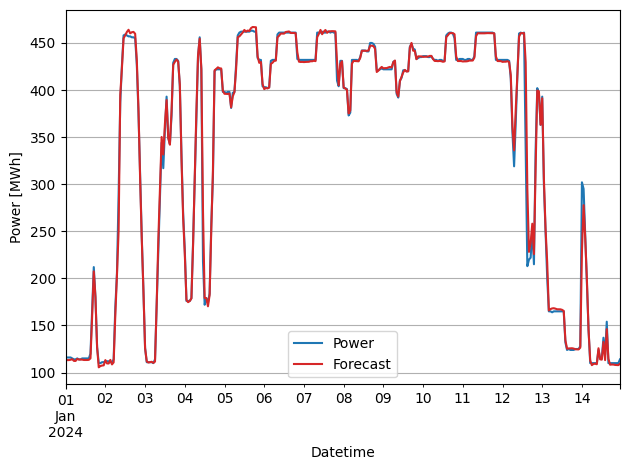

In [12]:
# plot
val_week = df_power.loc[predictions.index.min():predictions.index.max()]
fig, ax = plt.subplots()
val_week.plot(ax=ax, label='Actual Power', color='tab:blue')
predictions['pred'].plot(ax=ax, label='Forecast', color='tab:red')
plt.ylabel("Power [MWh]")
plt.xlabel("Datetime")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()